## Final Project Submission

- Student name: Jack Locke
- Student pace: Self-paced
- Instructor name: Mark Barbour

# H1N1 Flu Model Analysis

## Overview

- 1. Business Understanding
- 2. Data Understanding
- 3. Data Preparation
    - a. Merging Datasets
    - b. Dropping Unnecessary Columns
    - c. Handle Missing Values
    - d. Column Manipulation
    - e. Primary Column Information
- 4. Exploratory Data Analysis
    - a. Doctor Reccommendation vs. H1N1
    - b. Health Worker vs. H1N1
    - c. Opionion on Risk vs. H1N1
- 5. Modeling
    - a. Train, Validation, Holdout splits
    - b. Encoding Categorical Columns
    - c. Evaluation Metrics
    - d. Three Baseline Models
        - Logistic Regression
        - Decision Tree Classifier
        - Random Forest Classifier
    - e. Hyperparameter Tuning Best Model
    - f. Final Model
    - g. Adjusting Decision Threshold
        - Different Decision Thresholds
- 6. Conclusions
    - a. Limitations
    - b. Recommendations
- 7. Next Steps

## Business Understanding

The business stakeholder is a healthcare insurance company trying to predict individuals who received H1N1 vaccines so they can send them an additional survey and request medical records to acquire more information/knowledge. My project takes survey data about H1N1 vaccines using information they shared about their backgrounds, opinions, and health behaviors. The model aims to predict whether someone received the H1N1 vaccine or not. The importance of the model revolves around the costs associated with false positives and false negatives. The false positive would be predicting someone did receive the H1N1 vaccine when they didn’t (cost related to sending the survey to the wrong person). The false negative would be predicting someone didn't receive the H1N1 vaccine when they did (missed opportunity). I will find an appropriate trade-off between our two costs, focusing on minimizing missed opportunities. The company can use the additional information gained to help make better business decisions on their insurance policies, leading to more growth for the company. My analysis will use the CRISP-DM (Cross-industry standard process for data mining) methodology.


## Data Understanding

I am working with the National 2009 H1N1 Flu Survey dataset for this project. “In late 2009 and early 2010, the United States conducted the National 2009 H1N1 Flu Survey. This phone survey asked respondents whether they had received the H1N1 and seasonal flu vaccines, in conjunction with questions about themselves. These additional questions covered their social, economic, and demographic background, opinions on risks of illness and vaccine effectiveness, and behaviors towards mitigating transmission.”
The dataset contains over 26,000 rows and 38 columns. It is important to note that this is survey data, which, in general, has many limitations and biases. I will discuss these in more detail in the limitations section at the end of the notebook. Below is a link to the dataset and information on each feature.

Citation/Data: https://www.drivendata.org/competitions/66/flu-shot-learning/page/210/


In [164]:
#Import the necessary libraries for data manipulation, warnings, graphing, preprocessing, modeling, and metrics. 
import pandas as pd
import numpy as np
import re

pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [165]:
#Load in dataset with the h1n1 features.
vaccine = pd.read_csv('data/training_set_features.csv')
vaccine.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [166]:
#Load in dataset containing the h1n1 labels. 
vaccine_label = pd.read_csv('data/training_set_labels.csv')
vaccine_label.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


## Data Preparation

- A. Merging Datasets
- B. Dropping Unnecessary Columns
- C. Handle Missing Values
- D. Column Manipulation
- E. Primary Column Information

#### Merging Datasets

In [167]:
#Merge our h1n1 features and labels together.
vaccine = vaccine.merge(vaccine_label, on='respondent_id')

In [168]:
vaccine.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


#### Drop Unnecessary Columns

The dataset contains information on both the H1N1 vaccine and the seasonal flu vaccine. However, since I am only focused on the H1N1 vaccine for this project, I will remove the columns associated with the seasonal flu vaccine. During my data exploration, I also performed a Logit regression with statsmodels, which I used to remove features with p-values above 0.05. 

I also dropped three columns with almost 50% of the data missing: two employment-related columns and one on health insurance. These columns correlate with our target, but considering our business problem, I suggest removing these columns now so we do not lose half of the data. Then, in our follow-up survey, we will ask more specific questions about these topics.



In [169]:
#Drop the columns that are not necessary for our model.
vaccine.drop(columns=['seasonal_vaccine','respondent_id', 'doctor_recc_seasonal','opinion_seas_vacc_effective','opinion_seas_risk','opinion_seas_sick_from_vacc',
                     'employment_industry','employment_occupation','h1n1_knowledge','behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask','behavioral_outside_home',
                     'behavioral_touch_face','chronic_med_condition','rent_or_own','health_insurance'], inplace=True)

In [170]:
vaccine.isna().sum()

h1n1_concern                     92
behavioral_wash_hands            42
behavioral_large_gatherings      87
doctor_recc_h1n1               2160
child_under_6_months            820
health_worker                   804
opinion_h1n1_vacc_effective     391
opinion_h1n1_risk               388
opinion_h1n1_sick_from_vacc     395
age_group                         0
education                      1407
race                              0
sex                               0
income_poverty                 4423
marital_status                 1408
employment_status              1463
hhs_geo_region                    0
census_msa                        0
household_adults                249
household_children              249
h1n1_vaccine                      0
dtype: int64

#### Handling Missing Values

Most columns have missing values, but two in particular had over 2000 missing values. I manually fixed this issue with these two columns by filling in their mode values. I dropped all rows with missing values to resolve my problem with the remaining missing values. In this case, it works well because our dataset only goes from around 26,000 to around 24,000, so there is no significant loss in information. 

In [115]:
#Fill in columns that had a larger amount of missing values. Then dropping any rows with missing values.
vaccine['doctor_recc_h1n1'] = vaccine['doctor_recc_h1n1'].fillna(0.0)
vaccine['income_poverty'] = vaccine['income_poverty'].fillna('<= $75,000, Above Poverty')
vaccine = vaccine.dropna(how='any',axis=0)

#### Column Manipulation

In [116]:
#Changing the two columns pertaining to adults and children into just two values. 
vaccine['household_adults'] = vaccine['household_adults'].apply(lambda x: 'other adults' if x >= 1 else 'no other adults')
vaccine['household_children'] = vaccine['household_children'].apply(lambda x: 'children' if x >= 1 else 'no children')

#### Primary Column Information

The primary columns I will focus on in the EDA were decided based on the most significant coefficient estimates when running my Logit regression in statsmodels. I recommend that the company investigate these features further. I also included the target variable to help provide some additional context.  

In [117]:
#Receive information on the final dataframe that will be used for modeling.
vaccine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24658 entries, 0 to 26706
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 24658 non-null  float64
 1   behavioral_wash_hands        24658 non-null  float64
 2   behavioral_large_gatherings  24658 non-null  float64
 3   doctor_recc_h1n1             24658 non-null  float64
 4   child_under_6_months         24658 non-null  float64
 5   health_worker                24658 non-null  float64
 6   opinion_h1n1_vacc_effective  24658 non-null  float64
 7   opinion_h1n1_risk            24658 non-null  float64
 8   opinion_h1n1_sick_from_vacc  24658 non-null  float64
 9   age_group                    24658 non-null  object 
 10  education                    24658 non-null  object 
 11  race                         24658 non-null  object 
 12  sex                          24658 non-null  object 
 13  income_poverty       

In [118]:
#See the class imbalance present in our target variable. 
vaccine['h1n1_vaccine'].value_counts(normalize=True)

h1n1_vaccine
0    0.785303
1    0.214697
Name: proportion, dtype: float64

In [119]:
#See how often the doctor actually recommends the individual to receive the H1N1 vaccine. 
vaccine['doctor_recc_h1n1'].value_counts()

doctor_recc_h1n1
0.0    19583
1.0     5075
Name: count, dtype: int64

In [120]:
#See how many individuals in our dataset work in healthcare. 
vaccine['health_worker'].value_counts()

health_worker
0.0    21875
1.0     2783
Name: count, dtype: int64

In [121]:
#See the different opinions on individuals H1N1 risk. Will change column to high risk and low risk for the EDA. 
vaccine['opinion_h1n1_risk'].value_counts()

opinion_h1n1_risk
2.0    9439
1.0    7544
4.0    5119
5.0    1637
3.0     919
Name: count, dtype: int64

## Exploratory Data Analysis

As mentioned, my EDA will focus on the three most significant coefficient estimates, which had some of the largest impacts on our model. I will explore their relationships to our target variable, the H1N1 vaccine. This will help me understand patterns and trends within our dataset.


In [122]:
#The bar graph will show us the relationships between H1N1 and our most influential features. Creating a function
#for reusability for each one of our three recommendations. 
def bar_graph(x,y,df,title,xlabel,ylabel):
    
    '''
    The bar graph will take in our x-axis, y-axis, data needed, title for graph, and labels for our x axis and 
    y axis. 
    '''
    
    plt.figure(figsize=(14, 6))

    ax1 = sns.barplot(x=x,  y=y, data=df, color='darkblue')

    ax1.bar_label(ax1.containers[0],size=16)
    # show the graph

    plt.title(title,fontsize=20)
    plt.xlabel(xlabel,fontsize=18)
    plt.ylabel(ylabel,fontsize=18)
    plt.tick_params(axis='y',labelsize=16)
    plt.tick_params(axis='x',labelsize=16)
    plt.show()

#### Doctor Recommendation vs. H1N1

In [123]:
#Want to look at just data where the doctor recommended getting the H1N1 vaccine. Will group them together with the
#H1N1 vaccine to see how many ended up taking the doctors advice. 
doc_rec = vaccine[vaccine['doctor_recc_h1n1']==1].groupby('h1n1_vaccine')[['doctor_recc_h1n1']].count().sort_values(by='doctor_recc_h1n1',
                                                                                              ascending=False)

In [124]:
#Reseting index so they are both represented as columns for ease of graphing. 
doc_rec.reset_index(inplace=True)

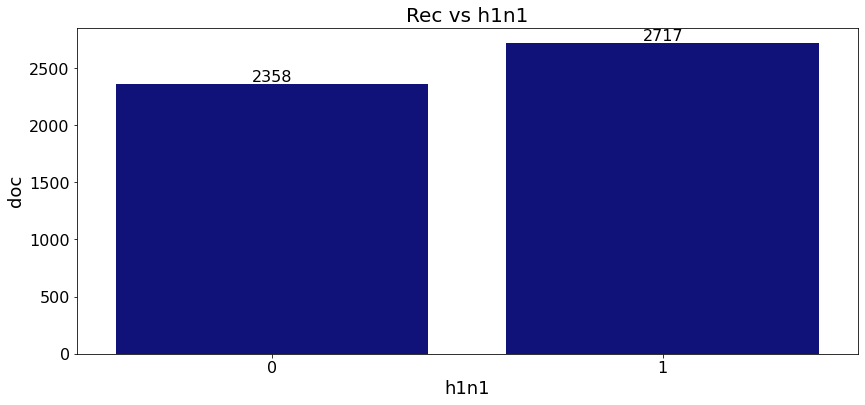

In [125]:
#Graphing our relationship of H1N1 and doctor recommendation. 
bar_graph('h1n1_vaccine','doctor_recc_h1n1',doc_rec,'Rec vs h1n1', 'h1n1', 'doc')

#### Health Worker vs. H1N1

In [126]:
##Want to look at data just pertaining to people who work in healthcare. Will group them together with the
#H1N1 vaccine to see how many healthcare workers get the H1N1 vaccine. 
health_work = vaccine[vaccine['health_worker'] == 1].groupby('h1n1_vaccine')[['health_worker']].count().sort_values(by='health_worker',
                                                                                              ascending=False)

In [127]:
#Reseting index so they are both represented as columns for ease of graphing. 
health_work.reset_index(inplace=True)

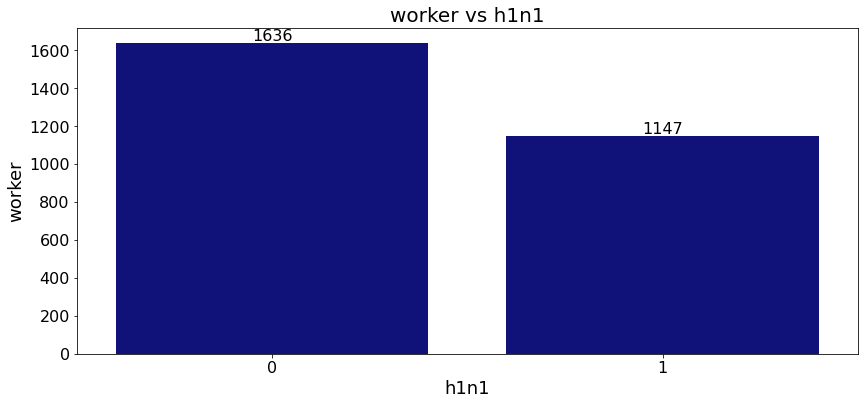

In [128]:
#Graphing our relationship of H1N1 and healthcare workers. 
bar_graph('h1n1_vaccine','health_worker',health_work,'worker vs h1n1', 'h1n1', 'worker')

#### Opinion on Risk vs. H1N1

In [129]:
#I am manipulating the opinion on risk column to make it easier to see the relationship with H1N1. Creating a copy
#of the vaccine dataframe in order to not affect the vaccine dataframe when doing this. 
risk = vaccine.copy()

In [130]:
#Removing risk of 3 because this is 'I don't know' so it will not have relevance for this EDA. 
risk = risk[risk['opinion_h1n1_risk']!=3.0]

In [131]:
#Setting values to either high risk or low risk based on their responses to the survey.
risk['opinion_h1n1_risk'] = risk['opinion_h1n1_risk'].apply(lambda x: 'high risk' if x > 3 else 'low risk')

In [132]:
#Looking at people who received the H1N1 vaccine to see what their level of risk was before receiving the vaccine. 
risk = risk[risk['h1n1_vaccine']==1].groupby('opinion_h1n1_risk')[['h1n1_vaccine']].count().sort_values(by='h1n1_vaccine',
                                                                                              ascending=False)

In [133]:
#Reseting index so they are both represented as columns for ease of graphing. 
risk.reset_index(inplace=True)

In [134]:
#Changing the column type to string so it graphs appropriately. 
risk['opinion_h1n1_risk'] = risk['opinion_h1n1_risk'].astype(str)

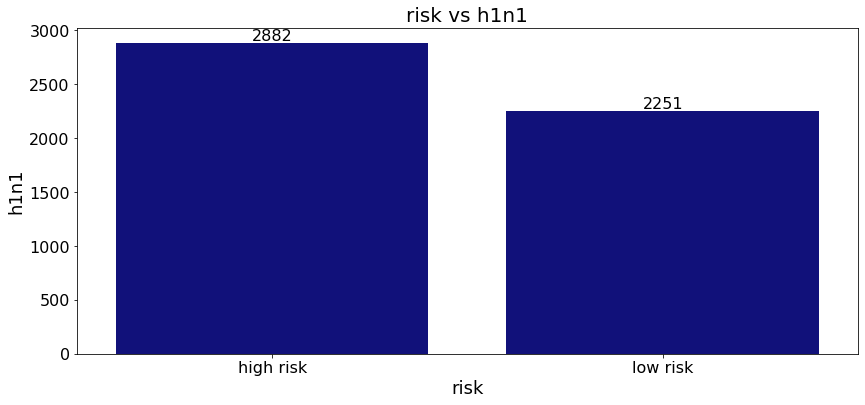

In [135]:
#Graphing our relationship of H1N1 and opinion on risk.
bar_graph('opinion_h1n1_risk','h1n1_vaccine', risk, 'risk vs h1n1', 'risk', 'h1n1')

## Modeling

In the modeling section of my notebook, I will split the dataset into three groups (train, valid, and holdout). The purpose is to demonstrate if our model is generalizable or not. This is a crucial step because if our model cannot perform similarly on both training data and unseen data, it will defeat the purpose of the model/project (the model has no value to the company). After that, I will encode the categorical columns in the vaccine dataframe to convert their values to binary. Otherwise, our models will not produce any results.

After that, I assessed the performance of three different binary classification models on the training data. The logistic regression model demonstrated the best fit, so I continued with that model. I then hyperparameter-tuned the logistic regression model with the training and validation data. I used a grid search to help give guidance/suggestions into what parameters were best. From there, I concluded my final model and ran the holdout data to confirm the model was performing similarly on the training data, validation data, and holdout data. After I confirmed it was, I adjusted the decision threshold in favor of recall to create the best-performing model for my business problem.


#### Train, Validation, Holdout Splits

In [136]:
# Define our X and y
X = vaccine.drop(columns = ['h1n1_vaccine'], axis=1)
y = vaccine['h1n1_vaccine']

In [137]:
#I need a train, valid, hold out split. Will need to create two splits. First split with have our holdout dataset.
X_train_all, X_hold_out, y_train_all, y_hold_out = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [138]:
#Second split, will be used for the train and validation data. 
X_train, X_valid, y_train, y_valid = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=42, stratify=y_train_all)

In [139]:
#Showing that each dataset split possesses similar percentage of y values. 
print("Train percent:", y_train.value_counts(normalize=True)[1])
print("Valid percent: ", y_valid.value_counts(normalize=True)[1])
print("Hold percent: ", y_hold_out.value_counts(normalize=True)[1])

Train percent: 0.21472427195403593
Valid percent:  0.21468799279116918
Hold percent:  0.21451743714517438


#### Encoding Categorical Columns

In [140]:
#I need to encode the categorical columns so I am creating a list containing all of the categorical columns that 
#need to be encoded. 
encoded_cols = []

for col in vaccine.columns:
    if vaccine[col].dtype == 'O':
        encoded_cols.append(col)
        
encoded_cols

['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults',
 'household_children']

In [141]:
#I am creating a custom encoding function that will contain OneHotEncoding. I want to avoid the dummy variable trap
#but I do not want to just drop the first column. The reason is, for each category, I want to drop the column that 
#posses the least amount of cardinality so I can increase the amount of information gain per category.
def encoding(data):
    
    '''
    The function is going to be passed in data, referring to each one of the datasets I will need to encode: 
    training, validation, holdout. What will happend is I will OneHotEncode each column one at a time. It will
    look at the additional columns created for each column, and find the one possessing the lease amount of 
    cardinality. It will then drop that column and concat the rest of the columns to a the encoded_vaccine 
    dataframe. Then I will concat the final encoded_vaccine dataframe to the original dataset 
    (training, validation, holdout).
    '''

    encoded_vaccine = pd.DataFrame()

    for col in encoded_cols:
    
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

        ohe.fit(data[[col]])

        vaccine_ohe = pd.DataFrame(
            ohe.transform(data[[col]]),
            index= data.index,
            columns=np.hstack(ohe.categories_)
        )
    
        col_dict = {}
        for col in vaccine_ohe.columns:
            col_dict[col] = vaccine_ohe[col].sum()
    
    
        
        minimum = [k for k,v in col_dict.items() if v == min(col_dict.values())]
    
    
        vaccine_ohe.drop(columns=minimum, inplace = True)
    
    
        encoded_vaccine = pd.concat([encoded_vaccine,vaccine_ohe], axis=1)
        

    data.drop(columns=encoded_cols,inplace = True)
    data = pd.concat([data, encoded_vaccine],axis=1)   

    return data

In [142]:
#Perform my custom encoding function on the training, validation, and holdout datasets. 
X_train = encoding(X_train)
X_valid = encoding(X_valid)
X_hold_out = encoding(X_hold_out)

#### Evaluation Metrics

In [143]:
#Creating a metrics function that will be reused for all of our modeling. It will contain the two metrics I am most
#focused on: recall and f1. 
def metrics_cv(cross_val_recall, cross_val_f1, model_type, data):
    
    '''
    The function will take in two cross validation scores. One for recall and one for f1. It will then print out
    the mean score for the train and test sets from the cross validation folds. Additionally, it will take in the 
    model type used (logistic regression), and which dataset it is being performed on (train, valid).
    '''
    
    print(f"{model_type} {data} cross validation scores:")
    print('\n')
    print("Recall scores - ")
    print(f"Average Train Score: {np.mean(cross_val_recall['train_score'])}")
    print(f"Average Test Score: {np.mean(cross_val_recall['test_score'])}")
    print('\n')
    print('F1 scores -')
    print(f"Average Train Score: {np.mean(cross_val_f1['train_score'])}")
    print(f"Average Test Score: {np.mean(cross_val_f1['test_score'])}")

#### Three Baseline Binary Classification Models: Logistic Regression, Decision Tree Classifier, Random Forest Classifier

I used the X_train dataset on the three baseline models to see their performance during cross-validation. I printed the mean values for the folds for both the train and test sets to see if the models were overfitting or underfitting. I will use the recall score to assess their performance and determine if the models are overfitting or underfitting. If they fit the same and the recall scores are similar, then I will evaluate the f1 score to assess their performance. Overall, the main emphasis is making sure the model is generalizable, meaning it will perform the same on my training data as on unseen data.

##### Logistic Regression

My logistic regression model is performing the same on both the training and test sets, showing a good overall fit. Our recall score is low, but this is expected for the baseline model. 

In [172]:
#Instantiate a LogisticRegression with random_state=42, and max_iter to 200 to avoid the convergence warning. 
baseline_model = LogisticRegression(random_state = 42,max_iter=200)
baseline_model.fit(X_train,y_train)


#Use cross_validate with scoring="recall" or "f1" to evaluate the model on X_train and y_train.
baseline_recall_logreg = cross_validate(baseline_model, X_train, y_train, scoring="recall", return_train_score=True)
baseline_f1_logreg = cross_validate(baseline_model, X_train, y_train, scoring="f1", return_train_score=True)

#Print out the metric results.
metrics_cv(baseline_recall_logreg,baseline_f1_logreg, 'Logistic Regression', 'X_train')

Logistic Regression X_train cross validation scores:


Recall scores - 
Average Train Score: 0.42674463543542895
Average Test Score: 0.4239302655975343


F1 scores -
Average Train Score: 0.528367371625545
Average Test Score: 0.5237681968145713


##### Decision Tree Classifier

Here, the training score is significantly better than the test scores, demonstrating extreme overfitting. This means that the model is not generalizable at this time. So far, the logistic regression is performing the best. 

In [145]:
#Instantiate a baseline Decision Tree Classifier.
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

#Use cross_val_score with scoring="recall" or "f1" to evaluate the model on X_train and y_train.
baseline_recall_dt = cross_validate(dt, X_train, y_train, scoring="recall", return_train_score=True)
baseline_f1_dt = cross_validate(dt, X_train, y_train, scoring="f1",return_train_score=True)

#Print out the metric results.
metrics_cv(baseline_recall_dt,baseline_f1_dt, 'Decision Tree Classifier', 'X_train')

Decision Tree Classifier X_train cross validation scores:


Recall scores - 
Average Train Score: 0.9961962696718623
Average Test Score: 0.47245917654788566


F1 scores -
Average Train Score: 0.9980944611990589
Average Test Score: 0.4617401358940641


##### Random Forest Classifier

Like the decision tree classifier, the training score performs much better than the test score. This is not surprising, considering a random forest is just an ensemble of decision trees. Therefore, logistic regression is the best-fitting model.

In [146]:
#Instantiate a baseline Random Forest Classifier.
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

#Use cross_val_score with scoring="recall" or "f1" to evaluate the model on X_train and y_train.
baseline_recall_rfc = cross_validate(rfc, X_train, y_train, scoring="recall", return_train_score=True)
baseline_f1_rfc = cross_validate(rfc, X_train, y_train, scoring="f1", return_train_score=True)

#Print out the metric results.
metrics_cv(baseline_recall_rfc, baseline_f1_rfc, 'Random Forest Classifier', 'X_train')

Random Forest Classifier X_train cross validation scores:


Recall scores - 
Average Train Score: 0.996917645667217
Average Test Score: 0.4076586756930613


F1 scores -
Average Train Score: 0.9980636635260212
Average Test Score: 0.5073957804389471


#### Hyperparameter Tuning on Best Model

As I mentioned previously, I used gridsearchCV as guidance to suggest some good-performing hyperparameters. As you can see below, I have set up a grid of different parameters with a list of some of their values. The grid search will create permutations of the parameters and compare their respective recall scores. Then, it will suggest the best-performing parameters based on those scores. The grid search was helpful, but the training and validation data showed slight underfitting/low regularization with C=.001. To adjust for this, I raised the C value slightly until I found the optimal point where the training and validation data performed similarly.

Additionally, the metric results showed that my recall score improved significantly, and my F1 score increased slightly, demonstrating the effectiveness of my hyperparameter tuning.


In [147]:
#Creating a grid that will be used to see which hyperparameters are the best. 
param_grid = {
    "solver": ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
    "C" : [1, 0.1, 0.01,.001], 
    "class_weight": ['balanced', None],
    "max_iter" : [100,200,500]
}

In [148]:
#Instantiating the grid search for the model, the grid, and what scores to focus: recall, f1. With a primary focus 
#on recall. 
grid = GridSearchCV(baseline_model, param_grid, scoring=['recall','f1'], refit='recall')

In [149]:
#Fitting the grid to the training data so it runs to see all the permutations of our hyperparameters. 
hypertune_model = grid.fit(X_train, y_train)

/Users/jacklocke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jacklocke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

/Users/jacklocke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jacklocke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

In [150]:
#Seeing the best suggested parameters from our grid search.
hypertune_model.best_params_

{'C': 0.001,
 'class_weight': 'balanced',
 'max_iter': 100,
 'solver': 'liblinear'}

In [176]:
#Instantiate our logistic regression with the best hyperparameters.
logreg_model = LogisticRegression(max_iter=100, random_state=42,class_weight='balanced', C=.006,solver='liblinear')
logreg_model.fit(X_train,y_train)


# Use cross_val_score with scoring="recall" or "f1" to evaluate the model on X_train and y_train
recall_logreg = cross_validate(logreg_model, X_train, y_train, scoring="recall", return_train_score=True)
recall_logreg_val = cross_validate(logreg_model, X_valid, y_valid, scoring="recall", return_train_score=True)
f1_logreg = cross_validate(logreg_model, X_train, y_train, scoring="f1",return_train_score=True)
f1_logreg_val = cross_validate(logreg_model, X_valid, y_valid, scoring="f1",return_train_score=True)

#Print the performance metrics for both the training data and the validation data. 
metrics_cv(recall_logreg, f1_logreg, 'Logistic Regression', 'X_train')
print('\n')
metrics_cv(recall_logreg_val, f1_logreg_val, 'Logistic Regression', 'X_valid')

Logistic Regression X_train cross validation scores:


Recall scores - 
Average Train Score: 0.726062939206082
Average Test Score: 0.7224621004943189


F1 scores -
Average Train Score: 0.5650899341197051
Average Test Score: 0.5628035803761209


Logistic Regression X_valid cross validation scores:


Recall scores - 
Average Train Score: 0.7492107064598577
Average Test Score: 0.7397850647561311


F1 scores -
Average Train Score: 0.5529504686737281
Average Test Score: 0.547021965783988


#### Final Model

Finally, I fit the training data into my final model and then used the final model to predict the holdout dataset. The model performed about the same on the training, validation, and holdout data, which makes me confident that it will perform the same on future unseen data.

In [152]:
#Creating/fitting our final model after hyperparameter tuning. 
final_model = logreg_model
final_model.fit(X_train,y_train)

LogisticRegression(C=0.006, class_weight='balanced', random_state=42,
                   solver='liblinear')

In [153]:
#Printing out the performance metrics with the holdout data to see how our model performs on unseen data. 
print("Recall:  ", recall_score(y_hold_out, final_model.predict(X_hold_out)))
print("f1:  ", f1_score(y_hold_out, final_model.predict(X_hold_out)))

Recall:   0.718336483931947
f1:   0.5608856088560885


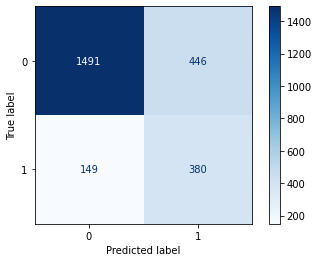

In [174]:
#Visual for the confusion matrix. 
cnf_matrix = confusion_matrix(y_hold_out, final_model.predict(X_hold_out))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=final_model.classes_)
disp.plot(cmap=plt.cm.Blues)

#### Adjusting Decision Threshold

My recall score is alright, but considering the business problem, I want to minimize my missed opportunity cost. So, I am adjusting the decision threshold in favor of my recall metric to increase my recall score. The trade-off is that this will also increase our cost of sending surveys to the wrong person. Below, I will show my recommended decision threshold. Then, I will outline two other decision thresholds and explain how each will affect cost differently.

In [204]:
#Adjusting the decision threshold in order to improve our recall score. Default is 0.5.
y_pred_new_threshold = (final_model.predict_proba(X_hold_out)[:, 1] >= 0.4).astype(int) 

In [205]:
#Printing the performance metrics after adjusting the decision threshold. 
print("Recall:  ", recall_score(y_hold_out, y_pred_new_threshold))
print("f1:  ", f1_score(y_hold_out, y_pred_new_threshold))

Recall:   0.8090737240075614
f1:   0.5080118694362018


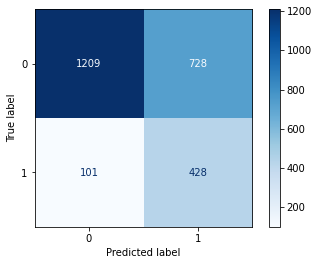

In [206]:
#Visual for the confusion matrix. 
cnf_matrix = confusion_matrix(y_hold_out, y_pred_new_threshold)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=final_model.classes_)
disp.plot(cmap=plt.cm.Blues)

##### Scenarios with different decision thresholds to show stakeholders
For the sake of the analysis, each survey costs about $1 to create/ship. And I will put the number of people I am surveying at 10000. The results will be based on our holdout test results (so these will be rough estimates). The recall score, the percentage of false positives, and the cost associated with sending out surveys will be shown below. Here, I can demonstrate to stakeholders how I can adjust the model to increase or decrease recall depending on the amount of money they wish to spend.

- Decision threshold 0.5: recall = ~72%,   ~18% FP,   cost = $1,800

- Decision threshold 0.4: recall = ~81%,   ~30% FP,   cost = $3,000

- Decision threshold 0.3: recall = ~91%,   ~48% FP,   cost = $4,800

## Conclusion

My Exploratory Data Analysis presents the relationship between three features with high coefficient estimates with the target variable, H1N1 vaccines. Additional information on these features should be included in the follow-up survey.  My model uses the information from all the features to help predict who received H1N1 vaccines, focusing on minimizing missed opportunity costs. The additional information gained from the follow-up survey and potential medical records would improve the insurance company’s knowledge, leading to better business decisions on their insurance policies. This will lead to more overall growth for the company. Given these findings and data enrichment in the future, I can build on my model recommendation and know where to proceed next.

### Limitations

At this stage, the data is limited, which is why the company wants to conduct additional surveys and obtain medical records. I do not have all the information on H1N1 vaccines. Specifically, I removed health insurance and employment information because it was missing too much data. Due to the lack of data, I cannot confidently say which features have the highest impact on determining if someone received the H1N1 vaccine, but I can show what is impactful at this time and recommend looking into it further. With data enrichment in the future (through the follow-up survey), I can start to reduce this limitation.

Additionally, survey data can be biased, inaccurate, and unreliable. Some people might not answer the survey truthfully because of outside factors, which could skew the results of any model I create. The company is also looking to acquire medical records to reduce this limitation. 


### Recommendations/Next Steps

For the follow-up survey, I recommend acquiring more data on health insurance, employment, and the three features I explored in the EDA. I also recommend using the logistic regression model with a decision threshold of 0.4; this threshold offers the best cost trade-off between missed opportunity costs and the cost of sending the survey to the wrong individual. I want to reduce the information limitation by acquiring more data through the follow-up survey. I also want to obtain medical records to reduce the limitations of biased/unreliable survey data. The additional information should help me create a more reliable model in the future, leading to more knowledge and overall growth for the company. 

- 1. **Doctor Recommendation**
- 2. **Health Worker**
- 3. **Opinion on H1N1 risk**
- 4. **Health Insurance**
- 5. **Employment Information**
- 6. **Medical Records**
- 7. **Logistic Regression Model with 0.4 threshold**